Run these code on bash first,

wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz
    
tar zxf ssd_inception_v2_coco_2018_01_28.tar.gz

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from object_detection import *
from plate_detection import detect_plate

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(1080, 1920, 3)


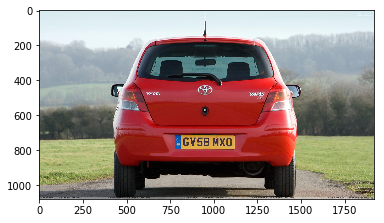

In [2]:
image = cv2.cvtColor(cv2.imread('back-car.jpg'), cv2.COLOR_BGR2RGB)
print(image.shape)
plt.imshow(image)
plt.show()

In [3]:
boxes, scores, classes, num_detections = detect_object(image)

In [4]:
car_only = [boxes[0,no,:] for no, c in enumerate(classes[0]) if c in [3,8] and scores[0,no] > 0.6]

In [5]:
def get_bounding_box(bbox, image):
    return int(bbox[0]*image.shape[0]),int(bbox[1]*image.shape[1]),\
    int(bbox[2]*image.shape[0]),int(bbox[3]*image.shape[1])

def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return cv2.medianBlur(gray, 3)

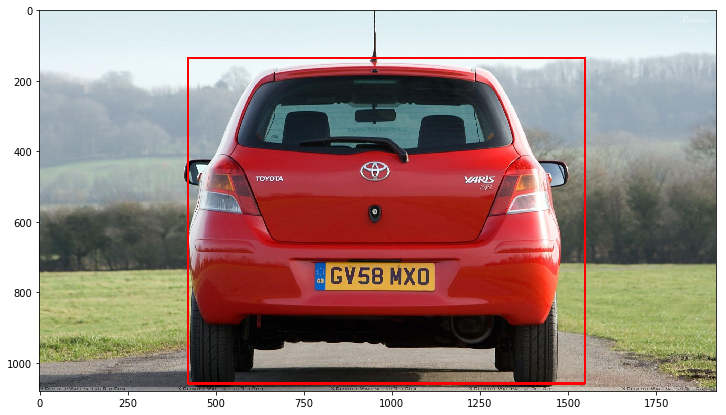

In [6]:
plt.figure(figsize = (15, 7))
copied = np.copy(image)
for car_boxes in car_only:
    ymin, xmin, ymax, xmax = get_bounding_box(car_boxes, image)
    cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)

plt.imshow(copied)
plt.show()

In [7]:
import pytesseract

def detecting_plate(img):
    
    boxes, _, _, _ = detect_plate(img)
    if not boxes.shape[1]:
        return
    ymin, xmin, ymax, xmax = get_bounding_box(boxes[0,0,:],img)
    img = img[ymin-10:ymax+10,xmin-10:xmax+10]
    copy_img = img.copy()
    
    img = cv2.bilateralFilter(img, 10, 20, 20)
    edged = cv2.Canny(img, 100,250)
    new, cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    plate, found = None, False

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            xmin, xmax = np.min(approx[:,0,0]), np.max(approx[:,0,0])
            ymin, ymax = np.min(approx[:,0,1]), np.max(approx[:,0,1])
            if (xmax - xmin > 50) and (ymax - ymin > 50):
                plate = approx
                found = True
                break
    if found:
        xmin, xmax = np.min(plate[:,0,0]), np.max(plate[:,0,0])
        ymin, ymax = np.min(plate[:,0,1])-5, np.max(plate[:,0,1])+5
        img = to_gray(img[ymin:ymax,xmin:xmax])
    else:
        img = to_gray(img)
    
    return pytesseract.image_to_string(img), img, edged

In [8]:
ymin, xmin, ymax, xmax = get_bounding_box(car_only[0],image)
plates = detecting_plate(image[ymin:ymax,xmin:xmax].copy())

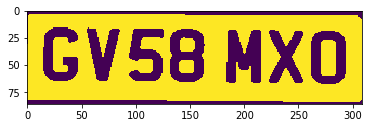

In [9]:
plt.imshow(plates[1])
plt.show()

In [10]:
plates[0]

'GVSB MXO'

In [11]:
h, w = image.shape[:2]
img_blend_out = image.copy()
off_x, off_y = 100, 30
thumb_h, thumb_w = (200, 300)
mask = cv2.rectangle(image.copy(), (0, 0), (w, 2 * off_y + thumb_h), (0, 0, 0), thickness=cv2.FILLED)
img_blend_out = cv2.addWeighted(src1=mask, alpha=0.3, src2=img_blend_out, beta=0.8, gamma=0)

In [12]:
cars = [image[ymin:ymax,xmin:xmax].copy()]
font = cv2.FONT_HERSHEY_SIMPLEX

In [13]:
for i, thumbnail in enumerate(cars):
    vehicle_thumb = cv2.resize(thumbnail, dsize=(thumb_w, thumb_h))
    start_x = 300 + (i+1) * off_x + i * thumb_w
    img_blend_out[off_y:off_y + thumb_h, start_x:start_x + thumb_w, :] = vehicle_thumb
    cv2.putText(img_blend_out, plates[0],
                (start_x, off_y + thumb_h + 50), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
cv2.putText(img_blend_out, 'Vehicles in sight: %d'%(len(car_only)),
                (20, off_y + thumb_h // 2), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

img_blend_out.shape

(1080, 1920, 3)

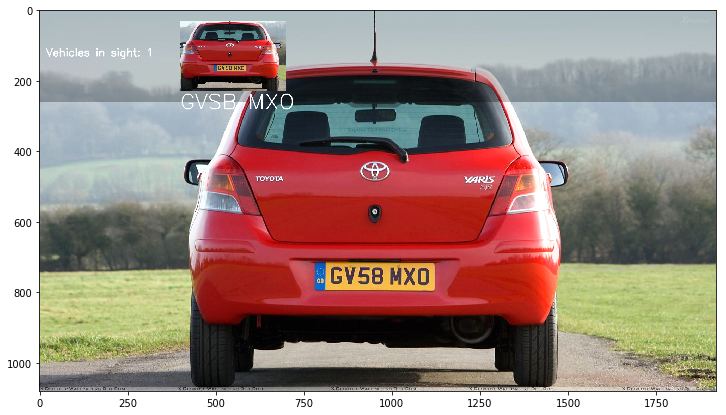

In [14]:
plt.figure(figsize = (15, 7))
plt.imshow(img_blend_out)
plt.show()

In [17]:
from scipy.misc import imsave
imsave('output-plate.jpg',img_blend_out)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
